In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

import matplotlib.pyplot as plt
# 设置中文字体支持
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置支持中文的字体，优先使用SimHei
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
sns.set_theme(style="white", font_scale=1.2)

df = pd.read_excel('filtered-ref-converted.xlsx')

bins = [27.5, 38]
labels = ['mid']
df['bmi_group'] = pd.cut(df['孕妇BMI'], bins=bins, labels=labels, right=True)

# 查看每个区间的数量
print(df['bmi_group'].value_counts())

# 获取各分组的数据

df_mid = df[df['bmi_group'] == 'mid'].copy()
print (len(df_mid))

bmi_group
mid    848
Name: count, dtype: int64
848


In [2]:
%load_ext autoreload
%autoreload 2

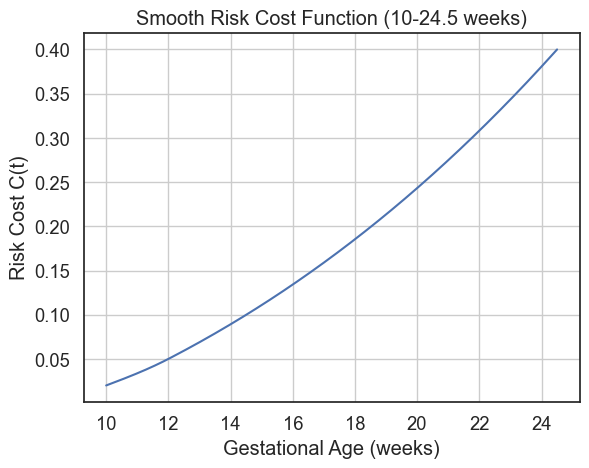

In [3]:
from scipy.interpolate import PchipInterpolator

# 风险成本
t_points = [10, 12, 24.5]

# 对应风险成本（可按中值或上界设定）
C_points = [0.02, 0.05, 0.40]  # 这里用小数表示 4%, 6%, 15%

# 构建 PCHIP 光滑插值
risk_cost = PchipInterpolator(t_points, C_points)

# 测试绘图
t = np.linspace(10, 24.5, 500)
C = risk_cost(t)

t = np.linspace(10, 24.5, 500)
C = risk_cost(t)

plt.plot(t, C)
plt.xlabel("Gestational Age (weeks)")
plt.ylabel("Risk Cost C(t)")
plt.title("Smooth Risk Cost Function (10-24.5 weeks)")
plt.grid(True)
plt.show()

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from copulas.multivariate import GaussianMultivariate
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import PchipInterpolator

# 加载数据
df = pd.read_excel('filtered-ref-converted.xlsx')

# BMI分组
bins = [27.5, 31.25, 33.5, 38]
labels = ['low', 'mid', 'high']
df['bmi_group'] = pd.cut(df['孕妇BMI'], bins=bins, labels=labels, right=True)

# 查看每个区间的数量 
print(df['bmi_group'].value_counts())

# 获取各分组的数据
df_low = df[df['bmi_group'] == 'low'].copy()
df_mid = df[df['bmi_group'] == 'mid'].copy()
df_high = df[df['bmi_group'] == 'high'].copy()

weeks = np.arange(10, 24.5, 0.25)

# 定义Copula优化函数
def fit_copula_and_optimize(df_group, lam=0.5, n_samples=5000):
    """
    输入:
        df_group: DataFrame, 至少包含 ['孕妇BMI', '孕周', 'Y染色体浓度']
        lam: 风险权重
        n_samples: copula采样数量
    输出:
        best_t: 最优孕周
        U_values: 效用函数曲线 (list)
        probabilities: 整体概率曲线 (list)
        samples: copula生成的样本
        prob_pred: 每个样本的个体化预测概率 (array)
    """
    data = df_group[['孕妇BMI', '孕周', 'Y染色体浓度']].dropna()
    if len(data) < 30:
        print("数据不足，跳过")
        return None, None, None, None, None

    # Copula 拟合
    copula = GaussianMultivariate()
    copula.fit(data)

    # 从拟合的 copula 里采样大规模数据
    samples = copula.sample(n_samples)

    # -------- 整体优化部分（和之前一样） --------
    weeks = np.arange(10, 24.5, 0.25)
    U_values = []
    probabilities = []

    for t in weeks:
        bmi_mean = data['孕妇BMI'].mean()
        cond = samples[
            (np.abs(samples['孕周'] - t) <= 0.3) &
            (np.abs(samples['孕妇BMI'] - bmi_mean) <= 1.0)
        ]

        if len(cond) == 0:
            prob = 0
        else:
            prob = np.mean(cond['Y染色体浓度'] >= 0.04)

        probabilities.append(prob)

        # 风险成本
        C = risk_cost(t)
        U = prob - lam * C
        U_values.append(U)

    best_idx = int(np.argmax(U_values))
    best_t = weeks[best_idx]

    # -------- 个体化预测部分 --------
    prob_pred = []
    for _, row in data.iterrows():
        t = row['孕周']
        bmi = row['孕妇BMI']

        cond = samples[
            (np.abs(samples['孕周'] - t) <= 0.3) &
            (np.abs(samples['孕妇BMI'] - bmi) <= 1.0)
        ]

        if len(cond) == 0:
            prob_pred.append(0.0)
        else:
            prob_pred.append(np.mean(cond['Y染色体浓度'] >= 0.04))

    prob_pred = np.array(prob_pred)

    return best_t, U_values, probabilities, samples, prob_pred

# 运行优化函数
best_low, U_low, prob_low, samples_low, prob_pred_low = fit_copula_and_optimize(df_low)
best_mid, U_mid, prob_mid, samples_mid, prob_pred_mid = fit_copula_and_optimize(df_mid)
best_high, U_high, prob_high, samples_high, prob_pred_high= fit_copula_and_optimize(df_high)

# 打印结果
print("低BMI最佳时点:", best_low)
print("中BMI最佳时点:", best_mid)
print("高BMI最佳时点:", best_high)

print (len(prob_mid))


bmi_group
low     390
mid     244
high    214
Name: count, dtype: int64


C:\Users\锤子\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_continuous_distns.py:709: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
C:\Users\锤子\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_continuous_distns.py:5574: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
C:\Users\锤子\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\锤子\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_continuous_distns.py:5574: RuntimeWarning: divide by zero encountered in divide
  return c**2 / (c**2 - n**2)
C:\Users\锤子\AppData\Roaming\Python\Python38\site-packages\scipy\stats\_distn_infrastructure.py:2789: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu
C:\Users\锤子\AppData\Roaming\Python\Python38\site-package

低BMI最佳时点: 14.75
中BMI最佳时点: 17.25
高BMI最佳时点: 14.0
58


C:\Users\锤子\AppData\Local\Temp\ipykernel_47292\3567732134.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


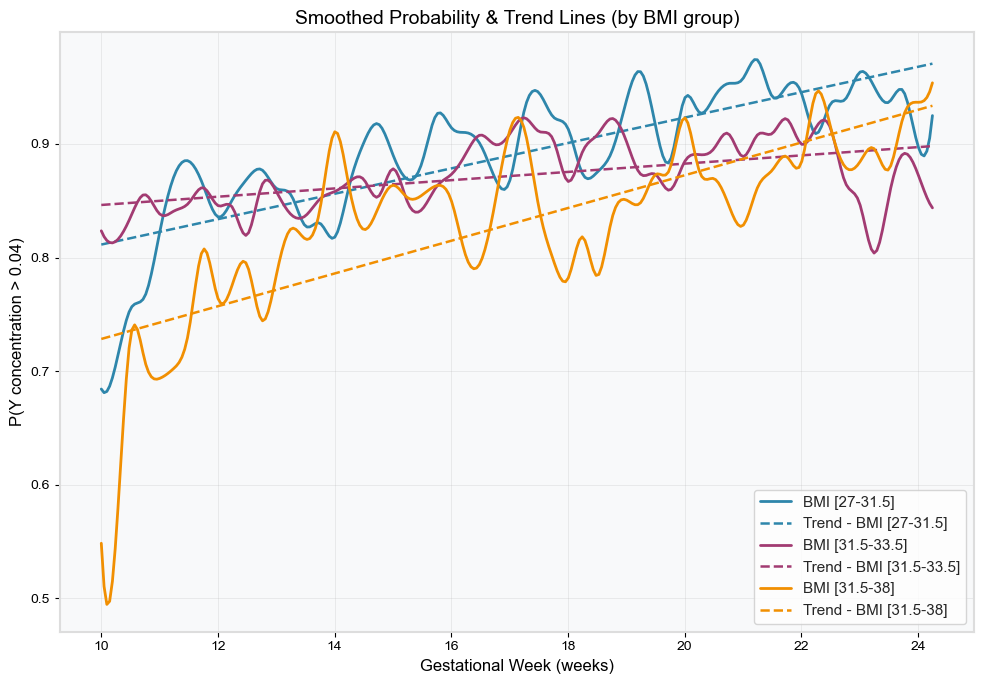

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline
plt.style.use('default')
sns.set_palette("husl")
# -------------------------
# 概率曲线 vs 孕周（单y轴 + 样条平滑 + 趋势直线）
# -------------------------
fig, ax = plt.subplots(figsize=(10, 7))

plt.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
plt.rcParams['font.size'] = 12

# 平滑函数
def smooth_curve(x, y, num=300):
    x = np.array(x)
    y = np.array(y)
    if len(x) < 4:  # 样条至少要4个点
        return x, y
    x_new = np.linspace(x.min(), x.max(), num)
    spline = make_interp_spline(x, y, k=3)
    y_smooth = spline(x_new)
    return x_new, y_smooth

# 画曲线 + 趋势线的函数
def plot_curve_and_trend(x, y, color, label):
    if y is None:
        return
    # 平滑曲线
    x_new, y_smooth = smooth_curve(x, y)
    ax.plot(x_new, y_smooth, color=color, linewidth=2, label=label)

    # 直线拟合（一次多项式）
    coeffs = np.polyfit(x, y, 1)
    trend = np.poly1d(coeffs)
    ax.plot(x, trend(x), color=color, linestyle="--", linewidth=1.8,
            label=f"Trend - {label}")

# 绘制三条曲线及趋势线#2E86AB #A23B72 #F18F01
plot_curve_and_trend(weeks, prob_low, "#2E86AB", "BMI [27-31.5]")
plot_curve_and_trend(weeks, prob_mid, "#A23B72", "BMI [31.5-33.5]")
plot_curve_and_trend(weeks, prob_high, "#F18F01", "BMI [31.5-38]")

# plot_curve_and_trend(weeks, prob_low, label = "BMI [27-31.5]")
# plot_curve_and_trend(weeks, prob_mid, label="BMI [31.5-33.5]")
# plot_curve_and_trend(weeks, prob_high, label="BMI [31.5-38]")


# 标签与标题
ax.set_xlabel("Gestational Week (weeks)", fontsize=12)
ax.set_ylabel("P(Y concentration > 0.04)", fontsize=12)
ax.set_title("Smoothed Probability & Trend Lines (by BMI group)", fontsize=14)

ax.legend(loc="best", frameon=True, fontsize=11)
ax.grid(alpha=0.3)


# 设置网格和样式
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.gca().set_facecolor('#F8F9FA')

# 美化边框
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.5)
    spine.set_color('#DDDDDD')

plt.tight_layout()
plt.show()


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import make_interp_spline

plt.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
plt.rcParams['font.size'] = 12

# 假设 long_df 已经存在，包含列 ['gest_week', 'Yconc', 'BMI']
# 先对 BMI 做分组
bins = [0, 31.5, 33.5, 40]  # 示例分组
labels = ['BMI <=31.5', '31.5<BMI<=33.5', 'BMI>33.5']
long_df['BMI_group'] = pd.cut(long_df['BMI'], bins=bins, labels=labels, include_lowest=True)

# 画散点 + 平滑曲线
fig, ax = plt.subplots(figsize=(10, 7))

colors = ['#2E86AB', '#A23B72', '#F18F01']

for i, grp in enumerate(labels):
    sub = long_df[long_df['BMI_group']==grp]
    if sub.empty:
        continue
    
    # 散点
    ax.scatter(sub['gest_week'], sub['Yconc'], alpha=0.5, s=20, color=colors[i], label=f"{grp} (points)")
    
    # 平滑曲线
    weeks = sub['gest_week'].values
    yvals = sub['Yconc'].values
    if len(weeks) >= 4:  # 样条至少4个点
        xnew = np.linspace(weeks.min(), weeks.max(), 300)
        spline = make_interp_spline(weeks, yvals, k=3)
        y_smooth = spline(xnew)
        ax.plot(xnew, y_smooth, color=colors[i], linewidth=2, label=f"{grp} (smooth)")

ax.set_xlabel("Gestational Week (weeks)", fontsize=12)
ax.set_ylabel("Y Chromosome Concentration", fontsize=12)
ax.set_title("Gestational Week vs Y Chromosome Concentration by BMI Group", fontsize=14)
ax.legend(loc="best", fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


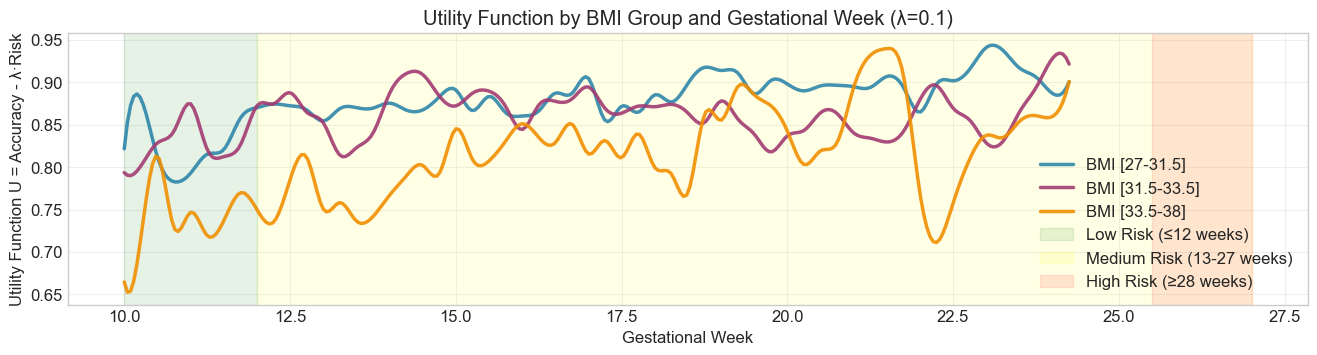

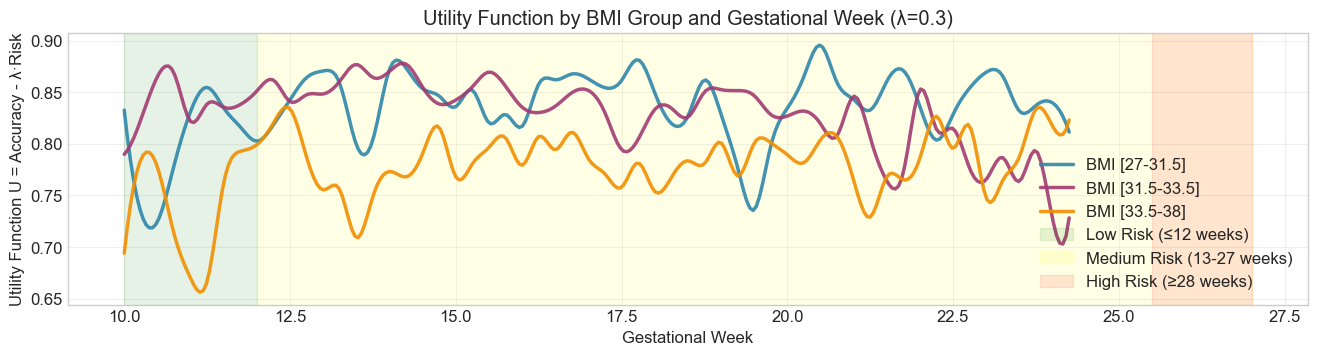

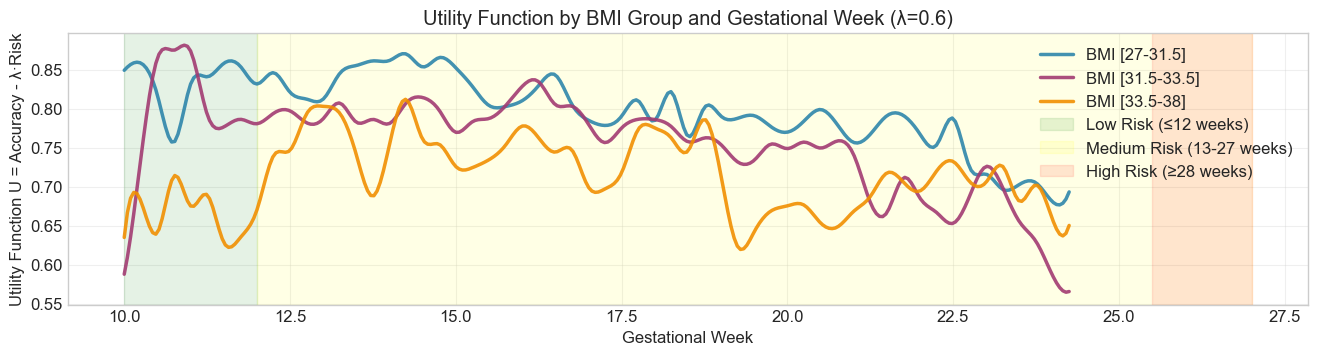

NIPT TESTING OPTIMIZATION RESULTS
BMI Group    Optimal Week    Risk Level  
------------------------------------------------------------
------------------------------------------------------------
RECOMMENDATIONS:
1. Lower BMI groups can test earlier with good accuracy
2. Higher BMI groups may need to test later for reliable results
3. Consider risk-benefit trade-off when choosing testing time


In [7]:
import warnings
warnings.filterwarnings('ignore')

def plot_U(lam):
    
    best_low, U_low, prob_low, samples_low, prob_pred_low = fit_copula_and_optimize(df_low,lam=lam)
    best_mid, U_mid, prob_mid, samples_mid, prob_pred_mid = fit_copula_and_optimize(df_mid, lam=lam)
    best_high, U_high, prob_high, samples_high, prob_pred_high = fit_copula_and_optimize(df_high, lam=lam)

    
    
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(3, 2, figure=fig)

# 孕周范围
    weeks = np.arange(10, 24.5, 0.25)

    ax1 = fig.add_subplot(gs[0, :])
    weeks_dense = np.linspace(weeks.min(), weeks.max(), 300)

    if U_low is not None:
    # 使用三次样条插值进行平滑
        spl_low = make_interp_spline(weeks, U_low, k=3)
        U_low_smooth = spl_low(weeks_dense)
        ax1.plot(weeks_dense, U_low_smooth, label=f'BMI [27-31.5]', 
                 linewidth=2.5, color='#2E86AB', alpha=0.9)
    # 标记最优解点
    #ax1.scatter(best_low, spl_low(best_low), color='#2E86AB', s=80, zorder=5, 
     #          edgecolors='white', linewidth=1.5)

    if U_mid is not None:
        spl_mid = make_interp_spline(weeks, U_mid, k=3)
        U_mid_smooth = spl_mid(weeks_dense)
        ax1.plot(weeks_dense, U_mid_smooth, label=f'BMI [31.5-33.5]', 
                 linewidth=2.5, color='#A23B72', alpha=0.9)
    #ax1.scatter(best_mid, spl_mid(best_mid), color='#A23B72', s=80, zorder=5,
     #          edgecolors='white', linewidth=1.5)

    if U_high is not None:
        spl_high = make_interp_spline(weeks, U_high, k=3)
        U_high_smooth = spl_high(weeks_dense)
        ax1.plot(weeks_dense, U_high_smooth, label=f'BMI [33.5-38]', 
                 linewidth=2.5, color='#F18F01', alpha=0.9)
    #ax1.scatter(best_high, spl_high(best_high), color='#F18F01', s=80, zorder=5,
     #          edgecolors='white', linewidth=1.5)


# 标记风险区域
    ax1.axvspan(10, 12, alpha=0.1, color='green', label='Low Risk (≤12 weeks)')
    ax1.axvspan(12, 27, alpha=0.1, color='yellow', label='Medium Risk (13-27 weeks)')
    ax1.axvspan(27, 25.5, alpha=0.1, color='red', label='High Risk (≥28 weeks)')

    ax1.set_xlabel('Gestational Week')
    ax1.set_ylabel('Utility Function U = Accuracy - λ·Risk')
    ax1.set_title(f'Utility Function by BMI Group and Gestational Week (λ={lam})')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    plt.savefig(f"P2_lam={lam}.png",dpi=300, format="png")
    plt.show()


plot_U(0.1)
plot_U(0.3)
plot_U(0.6)


# 输出结果摘要
print("=" * 60)
print("NIPT TESTING OPTIMIZATION RESULTS")
print("=" * 60)
print(f"{'BMI Group':<12} {'Optimal Week':<15} {'Risk Level':<12}")
print("-" * 60)

"""
for group, week in zip(bmi_groups, best_weeks):
    if week is not None:
        risk = "Low" if week <= 12 else "Medium" if week <= 27 else "High"
        print(f"{group:<12} {week:<15.1f} {risk:<12}")
"""


print("-" * 60)
print("RECOMMENDATIONS:")
print("1. Lower BMI groups can test earlier with good accuracy")
print("2. Higher BMI groups may need to test later for reliable results")
print("3. Consider risk-benefit trade-off when choosing testing time")
print("=" * 60)

In [8]:
from sklearn.utils import resample

n_boot = 5
best_weeks_boot = []

for i in range(n_boot):
    print(f"Bootstrap iteration {i+1}/{n_boot}")

    df_sample = resample(df_mid)  # 或df_low/df_high
    best_week, _, _, _ , _= fit_copula_and_optimize(df_sample, lam=0.5)
    best_weeks_boot.append(best_week)

# 输出置信区间
import numpy as np
ci_low, ci_high = np.percentile(best_weeks_boot, [2.5, 97.5])
print("95% CI for optimal week:", ci_low, ci_high)


Bootstrap iteration 1/5
Bootstrap iteration 2/5
Bootstrap iteration 3/5
Bootstrap iteration 4/5
Bootstrap iteration 5/5
95% CI for optimal week: 10.05 16.5


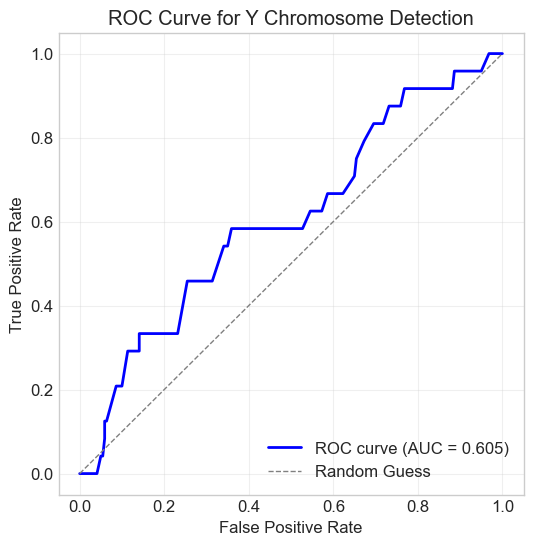

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# 插值概率
weeks = np.arange(10, 24.5, 0.25)
prob_interp = np.interp(df_mid['孕周'], weeks, prob_mid)

# 构造真实标签
y_true = (df_mid['Y染色体浓度'] >= 0.04).astype(int)

# 计算 ROC
fpr, tpr, thresholds = roc_curve(y_true, prob_interp)
roc_auc = auc(fpr, tpr)

# 画图
plt.figure(figsize=(6,6))
plt.plot(tpr, fpr, color='blue', lw=2, label=f' (AUC = {1-roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Y Chromosome Detection')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)


plt.show()


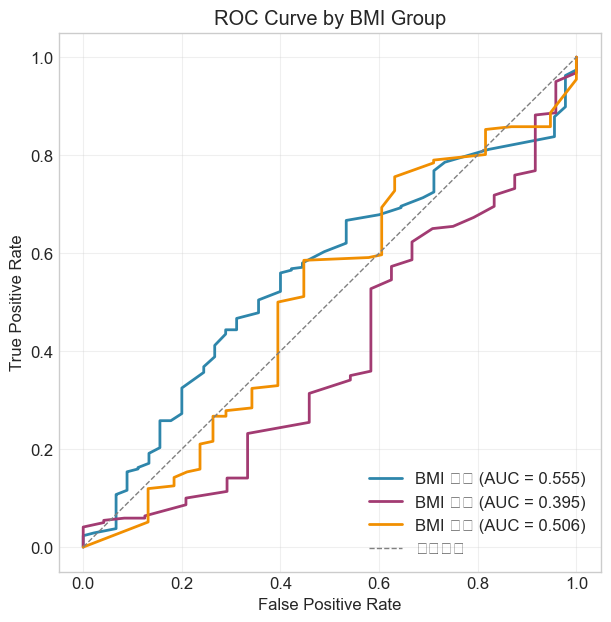

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

# 定义函数绘制单组 ROC
def plot_group_roc(df_group, prob_group, label_name, weeks):
    # 插值到每个样本孕周
    prob_interp = np.interp(df_group['孕周'], weeks, prob_group)
    y_true = (df_group['Y染色体浓度'] >= 0.04).astype(int)
    fpr, tpr, _ = roc_curve(y_true, prob_interp)
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, roc_auc, label_name

weeks = np.arange(10, 24.5, 0.25)

# 低 BMI
fpr_low, tpr_low, auc_low, label_low = plot_group_roc(df_low, prob_low, "BMI 低组", weeks)
# 中 BMI
fpr_mid, tpr_mid, auc_mid, label_mid = plot_group_roc(df_mid, prob_mid, "BMI 中组", weeks)
# 高 BMI
fpr_high, tpr_high, auc_high, label_high = plot_group_roc(df_high, prob_high, "BMI 高组", weeks)

# 绘图
plt.figure(figsize=(7,7))
plt.plot(fpr_low, tpr_low, lw=2, label=f'{label_low} (AUC = {auc_low:.3f})', color='#2E86AB')
plt.plot(fpr_mid, tpr_mid, lw=2, label=f'{label_mid} (AUC = {auc_mid:.3f})', color='#A23B72')
plt.plot(fpr_high, tpr_high, lw=2, label=f'{label_high} (AUC = {auc_high:.3f})', color='#F18F01')

plt.plot([0,1], [0,1], color='gray', lw=1, linestyle='--', label='随机猜测')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by BMI Group')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


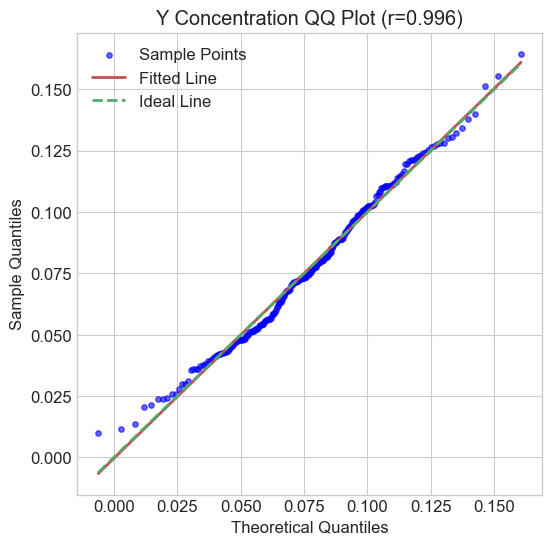

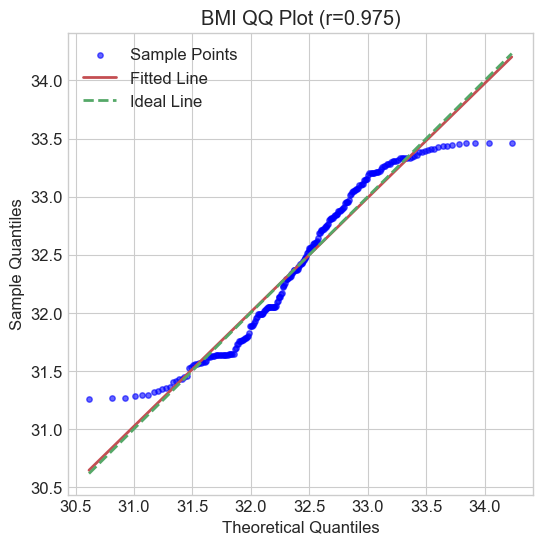

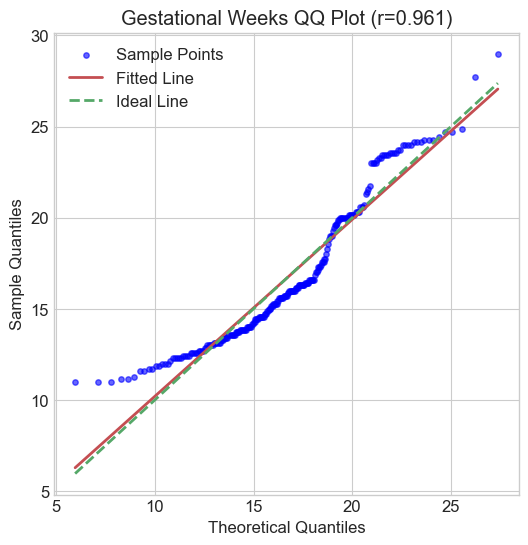

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

def plot_qq(data, dist="norm", title="QQ Plot"):
    """
    data: 1D array (e.g., gestational weeks, BMI, Y concentration)
    dist: distribution type, default 'norm'
    """
    # Fit distribution
    params = getattr(stats, dist).fit(data)
    
    # Generate theoretical quantiles
    (osm, osr), (slope, intercept, r) = stats.probplot(data, dist=dist, sparams=params)

    # Plot
    plt.figure(figsize=(6,6))
    plt.scatter(osm, osr, c="blue", s=15, alpha=0.6, label="Sample Points")
    plt.plot(osm, slope*osm + intercept, 'r-', lw=2, label="Fitted Line")
    plt.plot(osm, osm, 'g--', lw=2, label="Ideal Line")
    plt.xlabel("Theoretical Quantiles")
    plt.ylabel("Sample Quantiles")
    plt.title(title + f" (r={r:.3f})")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: check if Y-chromosome concentration is close to normal
plot_qq(df_mid['Y染色体浓度'].dropna(), dist="norm", title="Y Concentration QQ Plot")

plot_qq(df_mid['孕妇BMI'].dropna(), dist="norm", title="BMI QQ Plot")
plot_qq(df_mid['孕周'].dropna(), dist="norm", title="Gestational Weeks QQ Plot")

In [12]:
import numpy as np
import pandas as pd
from scipy.stats import kendalltau, spearmanr, pearsonr

x = np.random.normal(size=100)
y = 0.5*x + np.random.normal(size=100)

# 线性相关
print("Pearson:", pearsonr(x,y))
# 秩相关
print("Spearman:", spearmanr(x,y))
# Kendall tau
print("Kendall tau:", kendalltau(x,y))


Pearson: PearsonRResult(statistic=0.4545764081774841, pvalue=2.024537285228976e-06)
Spearman: SignificanceResult(statistic=0.44622862286228615, pvalue=3.269301996697848e-06)
Kendall tau: SignificanceResult(statistic=0.30989898989898995, pvalue=4.913884222989895e-06)


In [13]:
import numpy as np
import pandas as pd
from scipy.stats import kendalltau
from math import sin, pi

def kendall_tau_and_copula_params(df, cols):
    """
    输入:
      df   : pandas.DataFrame, 包含数据
      cols : list of str, 要计算的列名（两两计算）
    输出:
      results : list of dict, 每个 dict 包含 pair, tau, pvalue, and copula params
    """
    results = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            x = df[cols[i]].dropna()
            y = df[cols[j]].dropna()
            # 对齐 index: 只保留两列都存在的行
            common_idx = x.index.intersection(y.index)
            x = x.loc[common_idx].astype(float)
            y = y.loc[common_idx].astype(float)

            if len(x) < 3:
                continue

            tau, pvalue = kendalltau(x, y)
            # 映射到常用 copula 参数（closed-form）
            # Clayton: theta = 2*tau / (1 - tau), valid for tau in (0,1)
            theta_clayton = None
            if tau is not None and tau > -0.999 and (1 - tau) != 0:
                theta_clayton = 2.0 * tau / (1.0 - tau)

            # Gumbel: theta = 1 / (1 - tau), valid for tau in [0,1)
            theta_gumbel = None
            if tau is not None and tau < 1.0:
                theta_gumbel = 1.0 / (1.0 - tau)

            # Gaussian copula: relation tau = (2/pi) * arcsin(rho) => rho = sin(pi/2 * tau)
            rho_gaussian = None
            if tau is not None:
                rho_gaussian = sin((pi/2.0) * tau)

            results.append({
                'pair': (cols[i], cols[j]),
                'n_pairs': len(x),
                'kendall_tau': tau,
                'pvalue': pvalue,
                'clayton_theta': theta_clayton,
                'gumbel_theta': theta_gumbel,
                'gaussian_rho': rho_gaussian,
                # Frank 需要数值求解（见备注）
                'frank_note': "Frank theta requires numeric inversion of tau(theta)."
            })
    return results

# 用法示例（把列名改成你的实际列名）
cols = ['孕妇BMI', '孕周', 'Y染色体浓度']
res = kendall_tau_and_copula_params(df, cols)

# 打印美观一点
for r in res:
    print("-" * 60)
    print("Pair:", r['pair'])
    print("N:", r['n_pairs'])
    print("Kendall's tau = {:.6f}, p-value = {:.3e}".format(r['kendall_tau'], r['pvalue']))
    print("Clayton theta (≈) =", r['clayton_theta'])
    print("Gumbel theta (≈)  =", r['gumbel_theta'])
    print("Gaussian rho (≈)  =", r['gaussian_rho'])
    print(r['frank_note'])
print("-" * 60)


------------------------------------------------------------
Pair: ('孕妇BMI', '孕周')
N: 889
Kendall's tau = 0.080441, p-value = 3.670e-04
Clayton theta (≈) = 0.1749557555150365
Gumbel theta (≈)  = 1.0874778777575183
Gaussian rho (≈)  = 0.12602056231250716
Frank theta requires numeric inversion of tau(theta).
------------------------------------------------------------
Pair: ('孕妇BMI', 'Y染色体浓度')
N: 889
Kendall's tau = -0.091145, p-value = 4.783e-05
Clayton theta (≈) = -0.16706260849725452
Gumbel theta (≈)  = 0.9164686957513727
Gaussian rho (≈)  = -0.14268122310383807
Frank theta requires numeric inversion of tau(theta).
------------------------------------------------------------
Pair: ('孕周', 'Y染色体浓度')
N: 889
Kendall's tau = 0.056191, p-value = 1.277e-02
Clayton theta (≈) = 0.11907327684942683
Gumbel theta (≈)  = 1.0595366384247134
Gaussian rho (≈)  = 0.08815037244995104
Frank theta requires numeric inversion of tau(theta).
------------------------------------------------------------
